# Guided Walkthrough of Crash Modeling Tools

First, perform the necessary imports.

In [1]:
from crash_modeling_tools import *
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm

## Load in the initial data and see what predictors are available
Here we will look at crash data from I-90 in Washington State. The purpose of this demo is to show how the tool works, not to provide specific model results with deep meaning.

In [2]:
crash_data = pd.read_csv('../data/crash_modeling_tools_demo_data/crash_data_final_90.csv')
crash_data = crash_data.dropna()
crash_data.head()

,surf_typ,road_inv,lanewid,no_lanes,lshldwid,rshldwid,medwid,seg_lng,avg_grad,curve,aadt_09,acc_ct_09,aadt_10,acc_ct_10,aadt_11,acc_ct_11,avg_aadt,tot_acc_ct,log_avg_aadt
0,P,90,17,5,0,0,9,0.06,0.005839,Y,37402,8,38202,4,39409,4,38337.66667,16,10.55418816
1,P,90,17,5,0,0,50,0.02,0.008842,N,37402,6,38202,1,39409,5,38337.66667,12,10.55418816
2,P,90,21,4,0,0,50,0.02,0.030771,N,37402,0,38202,1,39409,1,38337.66667,2,10.55418816
3,P,90,21,4,0,0,50,0.02,0.028461,N,37402,0,38202,0,39409,1,38337.66667,1,10.55418816
4,P,90,21,4,0,0,50,0.09,0.023726,Y,37402,1,38202,2,39409,1,38337.66667,4,10.55418816


## Observe the summary statistics for the variables in our dataset
Here we consider two types of variables, namely continuous (cont) and categorical (cat). Below, we provide descriptions of each variable as well as its type. 
### Note: Not all variables will be used in the modeling.
- surf_typ (cat): surface type
- road_inv (n/a): road inventory number (i.e., route number), not a variable
- lanewid (cont): lane width in feet
- no_lanes (cont): number of lanes
- lshldwid (cont): left shoulder width in feet
- rshldwid (cont): right shoulder width in feet
- medwid (cont): median width in feet
- seg_lng (cont): segment length in feet
- avg_grad (cont): average grade of the road segment
- curve (cat): indicator for presence of curvature on the road segment
- aadt_09 (cont): annual average daily traffic count for road segment in 2009
- acc_ct_09 (cont): accident count for road segment in 2009
- aadt_10 (cont): annual average daily traffic count for road segment in 2010
- acc_ct_10 (cont): accident count for road segment in 2010
- aadt_1 (cont): annual average daily traffic count for road segment in 2011
- acc_ct_11 (cont): accident count for road segment in 2011
- avg_addt (cont): average value of annual average daily traffic count for road segment from 2009-2011
- tot_acc_count (cont): total accident count for road segment from 2009-2011
- log_avg_aadt(cont): natural logarithm of annual average daily traffic count from 2009-2011

## Show summary stats for the categorical variables we will consider

In [3]:
show_summary_stats(crash_data,[0,9])

,surf_typ,curve
count,480,480
unique,3,2
top,P,N
freq,348,389


## Show summary stats for the continuous variables

In [4]:
show_summary_stats(crash_data)

,road_inv,lanewid,no_lanes,lshldwid,rshldwid,medwid,seg_lng,avg_grad,aadt_09,acc_ct_09,aadt_10,acc_ct_10,aadt_11,acc_ct_11,tot_acc_ct
count,480,480.00000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.00000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,90,13.46875,6.200000,5.766667,8.031250,100.056250,0.089375,0.007154,63475.050000,1.33750,64947.141667,1.325000,65467.191667,1.368750,4.031250
std,0,3.02858,0.921558,3.944782,4.685636,125.393206,0.146069,0.051335,39300.517376,2.64509,40128.620670,2.715955,41123.621141,3.112951,7.857357
min,90,12.00000,4.000000,0.000000,0.000000,9.000000,0.010000,-0.052782,9867.000000,0.00000,9541.000000,0.000000,9198.000000,0.000000,0.000000
25%,90,12.00000,6.000000,0.000000,10.000000,48.000000,0.010000,-0.011502,30137.250000,0.00000,30717.250000,0.000000,29736.000000,0.000000,0.000000
50%,90,12.00000,6.000000,6.000000,10.000000,70.000000,0.040000,0.005799,54086.000000,1.00000,55173.000000,0.000000,55482.000000,0.000000,2.000000
75%,90,13.25000,7.000000,10.000000,10.000000,100.000000,0.100000,0.022863,101936.000000,2.00000,104117.000000,2.000000,107407.000000,1.000000,4.250000
max,90,26.00000,9.000000,18.000000,22.000000,999.000000,1.510000,1.000000,145774.000000,26.00000,149245.000000,31.000000,150021.000000,40.000000,97.000000


## Develop a crash frequency model
Here, we develop a model to predict crash frequency as a function of several characteristics of the roadway (here, we consider the annual average daily traffic, lane width, average grade, the presence of horizontal curvature, and surface type (e.g., asphalt concrete, portland cement concrete etc.) in our regression model). The model is a **negative binomial (NB) regression model** as is often the standard in highway safety modeling. The NB model is used to model count data and is preferrable to the Poisson model as it does not assume the mean and variance of the data are equal and is able to **account for such overdispersion (variance>mean)** by allowing the Poisson parameter to itself follow a gamma distribution.  **It is critical we include an offset term since the segments are not the same length.**

- Mean 3-year crash count in dataset = 2.46
- Varance of 3-year crash count in dataset = 26.41 
- Variance-to-mean ratio = 10.72 --> Overdispersion

### First compute the offset term 
The offset term equals the natural logarithm of the segment length times the duration of the study period (here, we consider 3 years: 2009, 2010, and 2011)

In [5]:
offset_term = np.log(crash_data['seg_lng'] * 3)

### Now estimate the regression model and output the summary

In [6]:
# need to cast log_avg_aadt to float since statsmodels thinks (incorrectly) that it is categorical
crash_data['log_aadt'] = crash_data.log_avg_aadt.astype(np.float)
mod_nb = smf.glm('tot_acc_ct~log_aadt+lanewid+avg_grad+C(curve)+C(surf_typ)',data=crash_data,offset=offset_term,
                 family=sm.families.NegativeBinomial()).fit()
mod_nb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             tot_acc_ct   No. Observations:                  480
Model:                            GLM   Df Residuals:                      473
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    log   Scale:                   1.79742136888
Method:                          IRLS   Log-Likelihood:                -1066.9
Date:                Tue, 15 Mar 2016   Deviance:                       489.80
Time:                        13:00:00   Pearson chi2:                     850.
No. Iterations:                    23                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -6.0144      1.482     -4.059      0.000        -8.919    -3.110
C(curve)[T.Y]       -0.4195      0.185     -2.265      0.023        -0.782    -0.057
C(surf_typ)[T.B]   -20.5734   5.65e+04     -0.000      1.000     -1.11e+05  1.11e+05
C(surf_typ)[T.P]     0.2804      0.187      1.495      0.135        -0.087     0.648
log_aadt             0.7762      0.133      5.853      0.000         0.516     1.036
lanewid              0.0324      0.025      1.279      0.201        -0.017     0.082
avg_grad             0.2042      1.306      0.156      0.876        -2.355     2.763
====================================================================================
"""

## We will now compute the value of the safety performance function (spf) on a data set also from I-90
The spf simply involves computing the value of the regression model for a set of sites (i.e., road segments). The results returned are the predicted crash counts for the segments as estimated via the previously developed NB regression model.

In [7]:
data_eb = pd.read_csv('../data/crash_modeling_tools_demo_data/crash_data_eb.csv')
data_eb = data_eb.dropna()
data_eb['log_aadt'] = data_eb.log_avg_aadt.astype(np.float)
compute_spf(mod_nb,data_eb)

array([ 13.33072731,  20.29096251,  23.20022988, ...,  18.76243423,
        14.9408838 ,  14.94893462])

## Implementation of the Emprical Bayes Method
Now, we will apply the Emprical Bayes (EB) method to computed the expected safety for each road segment. The EB method combines the expected crash count for each site as computed from the NB regression model and the observed crash count at each site in a weighted sum, where the weight factor is based on the dispersion parameter associated with the NB model (i.e., 1/scale parameter).

The EB method has many benefits including:
- Easier to implement than full Bayes method
- Takes into account variance of the SPF (i.e., regression model) estimate
- Provides more robust estimate of site safety by considering observed crash count in conjunction with predicted crash count from similar sites

The EB method is formulated as follows:
$${\pi}_i = w_i*SPF_i + (1-w_i)*K_i$$
Where,
- ${\pi}_i$ = expected safety for site i
- $w_i$ = weight factor for site i
- $SPF_i$ = safety performance function for site i
- $K_i$ = observed crash count for site i

The weight factor $w_i$ is calculated as follows:
$$w_i = 1 / (1 + SPF_i/(kL_i))$$
Where,
- $k = 1/(NB scale parameter)$
- $L_i$ = segment length
- All other variables as aforementioned


Below, we calculate the EB esimates for each site and display the first few rows (not ranked in any specific order):

In [8]:
eb_safety_estimates = estimate_empirical_bayes(mod_nb,data_eb,data_eb['seg_lng'],data_eb['tot_acc_ct'])
eb_safety_estimates.head()

,Safety
0,15.993333
1,12.004544
2,2.010163
3,1.010642
4,4.036799


## Calculation of Accident Reduction Potential

Accident Reduction Potential (ARP) is a commonly used method to rank/prioritize sites for safety improvement/treatment implementation. If $K_i$ (i.e., the observed crash count) is greater than $SPF_i$ (i.e., the predicted crash count), the ARP increases in value (compared to the converse) and the given site will be a high priority for treatment. The closer the value of $w_i$ is to 1, the higher the variance associated with the SPF, thus corresponding to lower ARP (low priority for treatment).

ARP is calculated as follows:
$$ARP_i = (1-w_i)(K_i-SPF_i)$$
Where,
- $ARP_i$ = accident reduction potential for site i
- $w_i$ = weight factor for site i
- $SPF_i$ = safety performance function for site i
- $K_i$ = observed crash count for site i

Below, we calculate ARP and show a few values (not in any particular order):

In [9]:
arp = calc_accid_reduc_potential(mod_nb,data_eb,data_eb['seg_lng'],data_eb['tot_acc_ct'])
arp.head()

,ARP
0,2.662605
1,-8.286418
2,-21.190067
3,-22.178651
4,-11.192678


## Confidence and Prediction Intervals for Negative Binomial Regression Model
The negative binomial model (and all other mixed-Poisson) regression models arise when an error term following a given distibution (known as the mixture distribution) enters the functional form of the Poisson parameter (denoted m). In the case of the NB model, the error term is gamma distributed which further implies that m itself follows a gamma distribution. Ultimately, there are three levels of variation in a mixed-Poisson model. Below, we describe these levels with respect to the NB model. WE then calculate and plot formulas for the confidence intervals (CIs) for $\mu$ and the prediction intervals (PIs) for m and y, as outlined in Wood (2005). Plotting of CIs and PIs gives a more complete picture for crash modeling as the user is presented with a range of values instead of just a point estimate as is obtained directly from a regression model.

**Three Levels of Hierarchy in a Mixed-Poisson Model:**
- Lowest level: mean response (**$\mu$**), also known as the Poisson mean, which itself follows a lognormal distribution (that can be approximated by a normal distribution)
- One level up: Poisson parameter (**m**), alternately known as the safety, which when conditioned on the Poisson mean ($\mu$), follows the mixture distribution (here, gamma)
- Finally: predicted response (**y**), i.e., the crash frequency at a new site which when conditioned on the Poisson parameter (m), follows a Poisson distribution

Interested users can find full specification of the formulas for the CIs and PIs in the source code or in the reference below.

**Reference:**

Wood, G. (2005). "Confidence and prediction intervals for generalised linear accident models" _Accident Analysis & Prevention_, 37(2), 267-273.

### Load in the data and compute the variance of the linear predictor

In [10]:
data_design = pd.read_csv('../data/crash_modeling_tools_demo_data/data_design.csv')
var_eta_hat = calc_var_eta_hat(mod_nb,data_design)

### Calculate the values of the Poisson mean

In [11]:
mu_hat = calc_mu_hat_nb(mod_nb,data_design)
mu_hat

array([[  4.70392914],
       [  4.74152609],
       [  4.77903726],
       ..., 
       [ 39.02027978],
       [ 39.04072842],
       [ 39.06117412]])

### Calculate confidence intervals the Poisson means (mu)

In [12]:
ci_mu_nb = calc_ci_mu_nb(mu_hat,var_eta_hat)
ci_mu_nb.head()

,LB CI mu,UB CI mu
0,2.933718,7.542289
1,2.962371,7.589214
2,2.991004,7.635964
3,3.019616,7.682541
4,3.048207,7.728949


### Calculate prediction intervals for the Poisson parameters (m)
#### LB = lower bound of interval, UB = upper bound of interval

In [13]:
pi_m_nb = calc_pi_m_nb(mod_nb,mu_hat,var_eta_hat)
pi_m_nb.head() 

,LB PI m,UB PI m
0,0,12.117840
1,0,12.210813
2,0,12.303559
3,0,12.396082
4,0,12.488385


### Calculate prediction intervals for the predicted responses (y)

In [14]:
pi_y_nb = calc_pi_y_nb(mod_nb,mu_hat,var_eta_hat)
pi_y_nb.head()

,LB PI y,UB PI y
0,0,21
1,0,21
2,0,21
3,0,21
4,0,21


## Plotting of the Intervals
Below, we generate a plot of the aforementioned confidence and prediction intervals (CIs and PIs, respectively) associated with the NB (aka Poisson-gamma) regression model.

In [15]:
% matplotlib inline
aadt_range = np.arange(9700,148400,100)

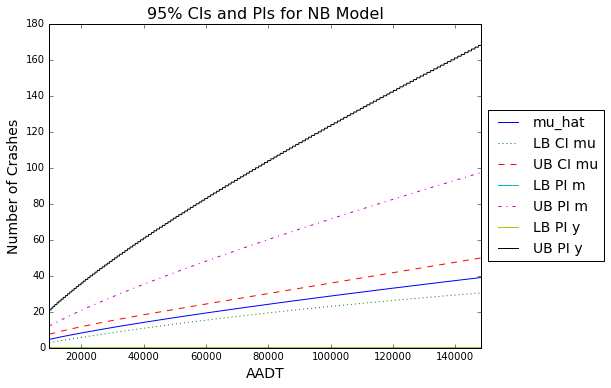

In [16]:
plot_and_save_nb_cis_and_pis(data_design,mod_nb,mu_hat,var_eta_hat,aadt_range,'AADT')